<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


# Metodología propuesta
#### 1. Selección del corpus:
Se seleccionó un corpus textual que sirviera como base para el entrenamiento del modelo de lenguaje. Este corpus debía ser representativo del dominio de interés y contener suficiente variabilidad léxica y sintáctica para permitir una generalización adecuada del modelo.

#### 2. Preprocesamiento del texto:
El corpus fue sometido a un proceso de preprocesamiento que incluyó:
* Conversión a minúsculas.
* Tokenización carácter a carácter.
* Codificación de los caracteres mediante índices enteros.
* Estructuración del conjunto de datos en secuencias de longitud fija.
* División en conjuntos de entrenamiento y validación.

#### 3. Diseño del modelo:
Se exploraron distintas arquitecturas de redes neuronales recurrentes para la tarea de modelado de lenguaje. En particular, se evaluaron modelos basados en *SimpleRNN*, *LSTM* y *GRU*, integrando capas de proyección y activación, y utilizando codificación *one-hot* como representación de entrada.

#### 4. Entrenamiento:
Los modelos fueron entrenados aplicando la perplejidad desde un *Callback ad-hoc*.

#### 5. Generación de texto
Los modelos entrenados fueron utilizados para generar nuevas secuencias a partir de contextos semilla. Se implementaron distintas estrategias de decodificación:
* *Greedy search:* selección del carácter más probable en cada paso.
* *Beam search determinista:* exploración de múltiples trayectorias con selección sistemática de los mejores candidatos.
* *Beam search estocástico:* incorporación de muestreo probabilístico controlado mediante un parámetro de temperatura, permitiendo analizar su impacto en la diversidad y coherencia de las secuencias generadas.

#### 6. Conclusiones: 
Se genearon las principales conclusiones basada en los resultados encontrados. 


## 1. Selección del corpus
Para generar un corpus con diferentes estilos personales de escritura, se utilizó un conjunto de datos publicado en Kaggle, titulado *ArXiv Scientific Research Papers Dataset*. Es importante mencionar que este dataset ha sido utilizado en tareas como clasificación de textos, sistemas de recomendación, análisis de tendencias, resumen automático, modelado de temas y análisis de impacto de autores. Por lo tanto, es una buena fuente de información para el corpus.

Este dataset esta compuesto por artículos del repositorio arXiv en áreas como inteligencia artificial, aprendizaje automático, informática y matemáticas. Este dataset, incluye campos como título, resumen, categoría, autores y fechas de publicación y actualización. Para los fines de este trabajo, se seleccionaron los 25 resúmenes más extensos (según número de palabras) de cada una de las cuatro categorías dominantes en el conjunto de datos. Posteriormente, dichos resúmenes fueron compilados en un único texto para su análisis.


Disponible en:
https://www.kaggle.com/datasets/sumitm004/arxiv-scientific-research-papers-dataset



In [161]:
import io
import pandas as pd
import re

# Conjunto de datos como archivo CSV    
dataset = pd.read_csv('./data/arXiv_scientific dataset.csv') 

# Rango Latin-1 con diacríticos
accent_pat = re.compile(r"[À-ÖØ-öø-ÿ]") 

mask_no_accents = ~dataset["summary"].str.contains(accent_pat, na=False)
mask_no_accents = ~dataset["title"].str.contains(accent_pat, na=False)
dataset = dataset[mask_no_accents].copy()

# Limpieza de los datos 
dataset = dataset.dropna(subset=['title','summary']).copy() 
dataset = dataset.drop_duplicates(subset=['title','summary'], keep='first').copy()

dataset.head(5)

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187


/tmp/ipykernel_477976/778474102.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


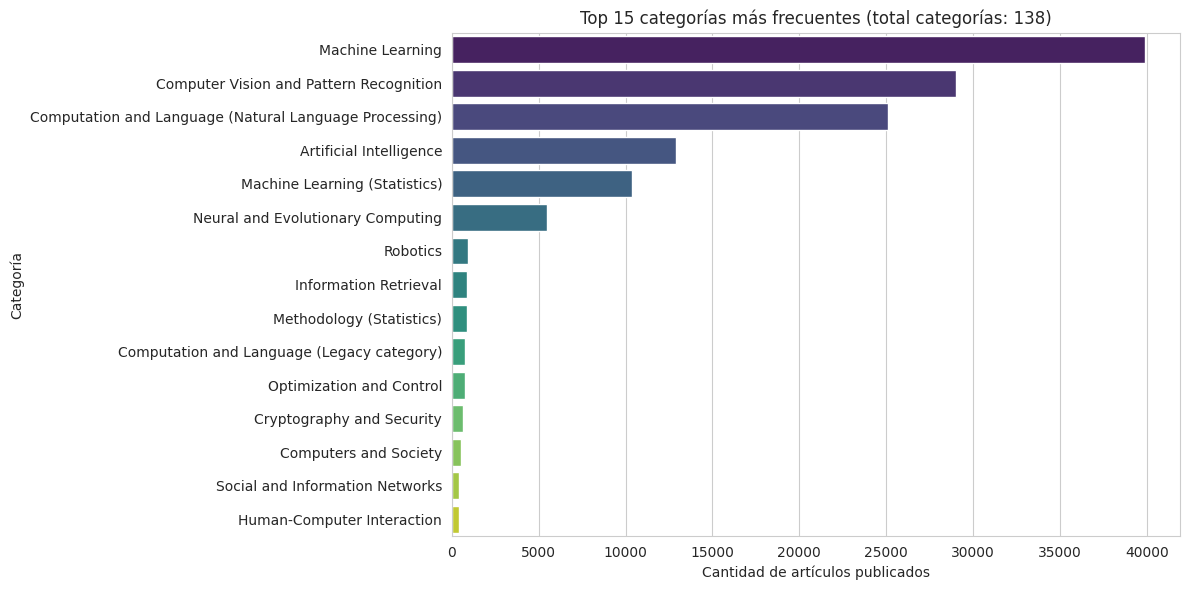

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 15 categorías más frecuentes
top_categories = dataset['category'].value_counts().head(15)
total = dataset['category'].nunique()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
plt.title(f'Top 15 categorías más frecuentes (total categorías: {total})')
plt.xlabel('Cantidad de artículos publicados')
plt.ylabel('Categoría')
plt.tight_layout()
plt.savefig('./figures/top15_categories_hist.png', dpi=150)
plt.show()


**Figura 1.** Top 15 categorías más frecuentes en el dataset.

Como se puede ver en la figura 1 la mayor cantidad de datos son sobre aprendizaje de máquina (*Machine Learning*, ML) seguido de visión por computador (*Computer Vision*, CV) y procesamiento de lenguaje natural (*Natural Language Processing*, PNL). Por lo tanto, desde el corpus el modelo entrenado esta sesgado hacía los algoritmos y procesamientos de estas disciplinas, por ejemplo, red neuronal recurrente (*Recurrent Neural Network*, RNN) y convolucional (*Convolutional Neural Network*, CNN). 

Por otro lado, hay que recategorizar a *Machine Learning (Statistics)* por *Machine Learning*.

In [163]:
import re

# En primer insatancia hay que recategorizar a Machine Learning (Statistics) por Machine Learning
dataset['category'] = dataset['category'].replace({
    'Machine Learning (Statistics)': 'Machine Learning'
})



## 2. Preprocesamiento del texto
Se construyó un modelo de lenguaje carácter a carácter mediante una serie de pasos de preprocesamiento aplicados sobre un corpus textual:

* **Construcción del vocabulario:** se extrajo el conjunto único de caracteres presentes en el texto (chars_vocab) y se definieron diccionarios de mapeo (*char2idx* y *idx2char*) para convertir caracteres en índices enteros y viceversa. Esta codificación facilitó el tratamiento del texto como una secuencia numérica.

* **Tokenización:** el corpus completo fue tokenizado, es decir, cada carácter fue reemplazado por su correspondiente índice numérico según el vocabulario previamente definido.

* **División del dataset y creación de secuencias**
Para preparar los datos para el entrenamiento y la validación, el corpus tokenizado fue segmentado y estructurado de la siguiente manera.
    *  **División del corpus:** el corpus tokenizado fue dividido en un conjunto de entrenamiento (90%) y un conjunto de validación (10%). La porción de validación fue reservada del final del corpus para asegurar una evaluación objetiva.
    *  **Generación de secuencias:** se utilizó una ventana deslizante de 100 caracteres con stride = 1 para generar secuencias superpuestas de entrada (*X*) y sus correspondientes salidas (*y*) en el conjunto de entrenamiento. En validación, en cambio, se construyeron bloques consecutivos sin superposición. Las secuencias se estructuraron bajo un esquema *many-to-many*, en el que cada salida es la entrada desplazada un carácter hacia adelante.

#### Contrucción del vocabulario

Se construyó un corpus textual concatenando los títulos y resúmenes de los artículos en formato secuencial. Cada entrada fue estructurada colocando el título, seguido por un salto de línea (*\n*), el resumen correspondiente, otro salto de línea, y luego el siguiente título, repitiendo este patrón.

Para esta tarea, se seleccionaron aleatoriamente 500 artículos del conjunto de datos original, y se utilizó esta muestra para generar un *"book"* continuo de texto, que sirvió como base para los análisis posteriores.

In [164]:
# Top 4 de categorías
top_100_categories = []
rank=0
for i in dataset['category'].value_counts().index[:4]:

    rank += 1
    print(f'{rank}. {i}')

    category_i = dataset[dataset['category'] == i]
    
    top_25_category_i = category_i.sort_values(by='summary_word_count', ascending=False).head(25)
    
    top_100_categories.append(top_25_category_i)

# Concatenar todos los DataFrames en top_100_categories
top_100_df = pd.concat(top_100_categories, ignore_index=True)

# Extraer la lista de IDs
top_ids = top_100_df['id']

dataset = dataset[dataset['id'].isin(top_ids)].copy()
dataset.head(3)

1. Machine Learning
2. Computer Vision and Pattern Recognition
3. Computation and Language (Natural Language Processing)
4. Artificial Intelligence


,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
655,abs-1105.5452v1,Unifying Class-Based Representation Formalisms,Artificial Intelligence,cs.AI,5/27/11,5/27/11,"['D. Calvanese', 'M. Lenzerini', 'D. Nardi']",'D. Calvanese',The notion of class is ubiquitous in computer ...,321
696,abs-1106.0252v1,Conformant Planning via Symbolic Model Checking,Artificial Intelligence,cs.AI,6/1/11,6/1/11,"['A. Cimatti', 'M. Roveri']",'A. Cimatti',We tackle the problem of planning in nondeterm...,320
728,abs-1106.1821v1,"Collective Intelligence, Data Routing and Brae...",Artificial Intelligence,cs.AI,6/9/11,6/9/11,"['K. Tumer', 'D. H. Wolpert']",'K. Tumer',We consider the problem of designing the the u...,333


/tmp/ipykernel_477976/3161068731.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


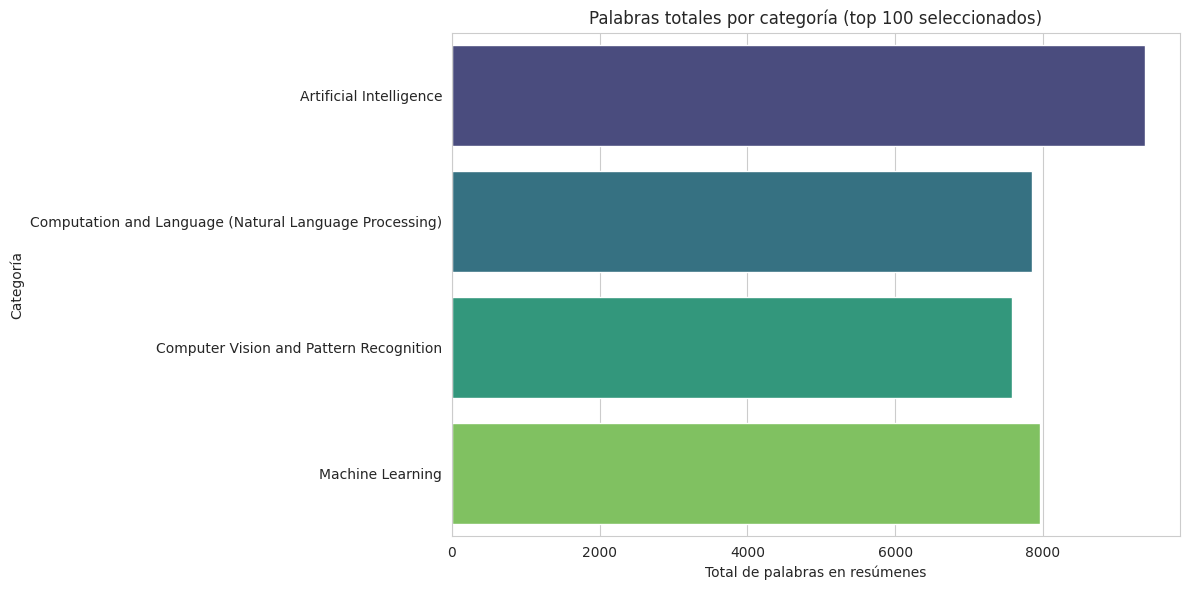

In [165]:
plt.figure(figsize=(12, 6))

sns.barplot(
    x='summary_word_count',
    y='category',
    data=dataset.groupby('category', as_index=False)['summary_word_count'].sum(),
    palette='viridis'
)

plt.title('Palabras totales por categoría (top 100 seleccionados)')
plt.xlabel('Total de palabras en resúmenes')
plt.ylabel('Categoría')
plt.tight_layout()
plt.savefig('./figures/top_categories_words_sum.png', dpi=150)
plt.show()


Al observar el dataset seleccionado, se observa una distribución uniforme entre las cuatro categorías seleccionadas. Por lo tanto, dado que el corpus es representativo para estas cagorias, los modelos generados no deberían presentar un sesgo hacía una de estas categorias

In [166]:
article_text = ''
for index, row in dataset.iterrows():
    article_text += row['title'] + ' \n' + row['summary'] + ' \n'    
article_text = article_text.lower()
article_text[:1000]

'unifying class-based representation formalisms \nthe notion of class is ubiquitous in computer science and is central in many\nformalisms for the representation of structured knowledge used both in\nknowledge representation and in databases. in this paper we study the basic\nissues underlying such representation formalisms and single out both their\ncommon characteristics and their distinguishing features. such investigation\nleads us to propose a unifying framework in which we are able to capture the\nfundamental aspects of several representation languages used in different\ncontexts. the proposed formalism is expressed in the style of description\nlogics, which have been introduced in knowledge representation as a means to\nprovide a semantically well-founded basis for the structural aspects of\nknowledge representation systems. the description logic considered in this\npaper is a subset of first order logic with nice computational characteristics.\nit is quite expressive and featur

En este caso se ve un texto sobre *ML* en el cual aparece un término especifico, *xgboost*, que es un algoritmo muy difundido en esta disciplina.

#### Preprocesamiento y codificación del Texto
Se definió un tamaño de contexto de 100 caracteres, que se utilizó como ventana deslizante para la generación de secuencias de entrada. El preprocesamiento del texto se llevó a cabo utilizando herramientas de la biblioteca Keras, en particular, la función *pad_sequences* fue incorporada para aplicar relleno (*padding*) en las secuencias cuando fue necesario (ver *./src/callback.py*).

El vocabulario se construyó a partir del conjunto único de caracteres presentes en el corpus completo (*article_text*). Luego, todos los caracteres fueron convertidos a minúsculas para reducir la dimensionalidad del vocabulario. Por último, a partir de este conjunto, se generaron dos diccionarios de mapeo:

- *char2idx*: asignó un índice numérico único a cada carácter (tokenización).

- *idx2char*: permitió la conversión inversa, de índices a caracteres.

La longitud total del vocabulario de caracteres fue registrada para ser utilizada en etapas posteriores del modelo de lenguaje.

In [167]:
# Definición del tamaño de contexto para las secuencias de entrada (número de caracteres utilizados como ventana de entrada)
# Se define un tamaño de contexto de 100 caracteres, por lo tanto, no es necesario utilizar padding (from tensorflow.keras.utils import pad_sequences) 
max_context_size = 100

# Extracción del vocabulario de caracteres: conjunto único de caracteres presentes en todo el corpus de texto
chars_vocab = set(article_text)

# Tamaño del vocabulario de caracteres
vocab_size = len(chars_vocab)

print(f'''
      El vacabulary de caracteres es: {chars_vocab}
      Número total de caracteres únicos en el conjunto de datos: {vocab_size}
''')



      El vacabulary de caracteres es: {'c', '1', 'r', '@', '-', '(', 'k', 'z', '}', '2', '9', '4', '>', 't', 'e', 'v', 'x', '\n', '<', '.', 'q', '%', '8', '$', ']', '^', ')', 'i', 's', '"', ';', '?', '=', ':', '{', 'h', 'm', 'a', 'd', 'u', 'n', ' ', 'p', 'f', 'w', 'j', '[', 'g', 'o', '/', '|', 'b', 'l', '7', '+', '`', ',', '0', '5', '&', 'y', '*', '_', '6', '3', '\\', "'", '~'}
      Número total de caracteres únicos en el conjunto de datos: 68



In [168]:
# Construcción de los diccionarios de mapeo entre caracteres e índices numéricos
# `char2idx` actúa como tokenizador (carácter → índice)
char2idx = {k: v for v, k in enumerate(chars_vocab)}
print(f'char2idx (primeros 10): {list(char2idx.items())[:10]}')

# `idx2char` permite la conversión inversa (índice → carácter)
idx2char = {v: k for k, v in char2idx.items()}
print(f'idx2char (primeros 10): {list(idx2char.items())[:10]}')


char2idx (primeros 10): [('c', 0), ('1', 1), ('r', 2), ('@', 3), ('-', 4), ('(', 5), ('k', 6), ('z', 7), ('}', 8), ('2', 9)]
idx2char (primeros 10): [(0, 'c'), (1, '1'), (2, 'r'), (3, '@'), (4, '-'), (5, '('), (6, 'k'), (7, 'z'), (8, '}'), (9, '2')]


Como se puede ver en la primera tupla de la salida, *(0, c)*, el índice *0* se asocia con el carácter *c*. Esto significa que cuando el modelo encuentra el índice *0*, lo interpretará como el carácter *c*. Por lo tanto, al buscar el índice *0* en *idx2char*, se utiliza *0* como clave para mapear en el diccionario, y se devuelve su valor asociado que es el carácter *c*.

###  Tokenización

In [169]:
# Tokenización del texto completo: cada carácter del corpus se convierte en su índice correspondiente según el diccionario `char2idx`
tokenized_text = [char2idx[ch] for ch in article_text]

# Visualización de los primeros 1000 caracteres tokenizados
print(tokenized_text[:1000])


[39, 40, 27, 43, 60, 27, 40, 47, 41, 0, 52, 37, 28, 28, 4, 51, 37, 28, 14, 38, 41, 2, 14, 42, 2, 14, 28, 14, 40, 13, 37, 13, 27, 48, 40, 41, 43, 48, 2, 36, 37, 52, 27, 28, 36, 28, 41, 17, 13, 35, 14, 41, 40, 48, 13, 27, 48, 40, 41, 48, 43, 41, 0, 52, 37, 28, 28, 41, 27, 28, 41, 39, 51, 27, 20, 39, 27, 13, 48, 39, 28, 41, 27, 40, 41, 0, 48, 36, 42, 39, 13, 14, 2, 41, 28, 0, 27, 14, 40, 0, 14, 41, 37, 40, 38, 41, 27, 28, 41, 0, 14, 40, 13, 2, 37, 52, 41, 27, 40, 41, 36, 37, 40, 60, 17, 43, 48, 2, 36, 37, 52, 27, 28, 36, 28, 41, 43, 48, 2, 41, 13, 35, 14, 41, 2, 14, 42, 2, 14, 28, 14, 40, 13, 37, 13, 27, 48, 40, 41, 48, 43, 41, 28, 13, 2, 39, 0, 13, 39, 2, 14, 38, 41, 6, 40, 48, 44, 52, 14, 38, 47, 14, 41, 39, 28, 14, 38, 41, 51, 48, 13, 35, 41, 27, 40, 17, 6, 40, 48, 44, 52, 14, 38, 47, 14, 41, 2, 14, 42, 2, 14, 28, 14, 40, 13, 37, 13, 27, 48, 40, 41, 37, 40, 38, 41, 27, 40, 41, 38, 37, 13, 37, 51, 37, 28, 14, 28, 19, 41, 27, 40, 41, 13, 35, 27, 28, 41, 42, 37, 42, 14, 2, 41, 44, 14, 41,

Se obervan los primeros 1000 caracteres tokenizados en valores de índice del diccionario.

### División del dataset y creación de secuencias
Una vez completado el proceso de tokenización, el corpus numérico se dividió y estructuró para su uso en el entrenamiento y validación de cada modelo evaluado.

#### División del corpus
Para preparar los datos para el entrenamiento y la validación, el texto tokenizado se segmentó en dos subconjuntos. El 10% final del corpus se reservó para el conjunto de validación, mientras que el 90% restante se destinó al conjunto de entrenamiento. Por lo tanto, esto asegura que el modelo sea evaluado con datos que no ha visto durante el entrenamiento, proporcionando una medida objetiva de su capacidad de generalización.

In [170]:
import numpy as np
# Separación del dataset en entrenamiento y validación.
# Definición de la proporción del corpus que será reservada para validación
p_val = 0.1

# Cálculo del número de secuencias de longitud `max_context_size` destinadas a validación
num_val = int(np.ceil(len(tokenized_text) * p_val / max_context_size))

# División del corpus tokenizado en conjunto de entrenamiento y validación
# La parte final del corpus se reserva para validación; el resto se usa para entrenamiento
train_text = tokenized_text[:-num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size:]


#### Generación de las secuencias
Las secuencias de entrada y salida fueron generadas para entrenar modelos de lenguaje de carácter a carácter. Según el propósito (entrenamiento o validación) fue la  estrategia aplicada en la creación de secuencias:

* Secuencias de entrenamiento (con superposición):
A partir del conjunto de entrenamiento, se utilizó una ventana deslizante con *stride = 1*, es decir, la ventana se muevió un carácter a la vez. Esto genera un gran número de secuencias altamente superpuestas, lo que permite al modelo ver múltiples contextos similares y mejorar su capacidad de generalización.

* Secuencias de validación (sin superposición):
Se generaron bloques consecutivos de longitud fija (*max_context_size*) a partir del conjunto de validación. Por lo tanto, cada bloque fue independiente, no hubo superposición entre ellos. Esta estructura es adecuada para evaluar el modelo de forma ordenada y sin redundancias durante el cálculo de métricas como la Perplejidad.

* Construcción de *X* e *y*:
Para cada secuencia de entrada *X[i]*, se asigna como salida esperada la siguiente secuencia *X[i+1]*. Esto permite que el modelo aprenda a predecir el siguiente carácter en una secuencia paso a paso, lo que se conoce como un enfoque many-to-many.

* Ejemplo:
Si *X[0] = [a, b, c]*, entonces *y[0] = [b, c, d]*.

In [176]:
# Generación de las secuencias de entrenamiento con una ventana deslizante (stride = 1)
tokenized_sentences_train = [
    train_text[init : init + max_context_size]
    for init in range(len(train_text) - max_context_size + 1)
]

# Generación de las secuencias de validación (sin superposición): bloques consecutivos de `max_context_size` caracteres
tokenized_sentences_val = [
    val_text[init * max_context_size : init * (max_context_size + 1)]
    for init in range(num_val)
]

# Construcción de los arrays de entrada (X) y salida (y) para entrenamiento supervisado
# Cada entrada X[i] se asocia con la siguiente secuencia de entrada X[i+1], que actúa como salida esperada
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

print(f'''
      Dimensión de X: {X.shape} y sus primeras 5 secuencias y 5 tokens:
      {X[:5,:5]},
      
      Dimension de y: {y.shape} y sus primeras 5 secuencias y 5 tokens:
      {y[:5,:5]}
      
      Tamaño del vocabulario: {vocab_size}
''')



      Dimensión de X: (194674, 100) y sus primeras 5 secuencias y 5 tokens:
      [[39 40 27 43 60]
 [40 27 43 60 27]
 [27 43 60 27 40]
 [43 60 27 40 47]
 [60 27 40 47 41]],

      Dimension de y: (194674, 100) y sus primeras 5 secuencias y 5 tokens:
      [[40 27 43 60 27]
 [27 43 60 27 40]
 [43 60 27 40 47]
 [60 27 40 47 41]
 [27 40 47 41  0]]

      Tamaño del vocabulario: 68



Se estructuró el problema de aprendizaje siguiendo un esquema *many-to-many*.

La entrada fue definida como una secuencia de tokens [$x_0$, $x_1$, ..., $x_N$], mientras que la salida objetivo correspondió a la misma secuencia desplazada una posición hacia adelante: [$x_1$, $x_2$, ..., $x_{N+1}$]. De este modo, se requería que la red aprendiera a predecir el carácter siguiente en cada paso temporal.

Al estructurarse el aprendizaje de esta forma, se permitió que una señal de gradiente se propagara en cada paso de la secuencia a lo largo del grafo de cómputo recurrente, lo cual resultó más eficiente que un enfoque many-to-one, en el que solo una única señal de error se propaga.

En esta etapa, las secuencias fueron tokenizadas y almacenadas en la variable *tokenized_sentences*. A partir de ellas, se extrajo un subconjunto que fue utilizado como conjunto de validación, con el fin de evaluar la calidad de las secuencias generadas mediante la métrica de Perplejidad.

## 3. Diseño del modelo:
Se implementaron y evaluaron tres arquitecturas recurrentes clásicas para modelado de lenguaje carácter a carácter: *SimpleRNN*, *LSTM* y *GRU*. Estas variantes permiten comparar el desempeño de diferentes mecanismos de memoria y control secuencial sobre el mismo conjunto de datos y tareas.

El modelo propuesto consume directamente índices enteros correspondientes a caracteres tokenizados, sin emplear una capa de embedding entrenable. En su lugar, la representación vectorial de cada carácter se realiza mediante codificación *one-hot* (OHE), aplicada a cada paso temporal de la secuencia.

Esta transformación se implementó combinando las siguientes capas de *Keras*:

- **CategoryEncoding:** transforma los índices enteros en vectores one-hot de dimensión igual al tamaño del vocabulario de caracteres.

- **TimeDistributed:** permite aplicar la codificación *one-hot* a cada paso temporal de la secuencia, preservando así la estructura secuencial del *input*.

Este diseño permite que la red procese la información carácter por carácter manteniendo la semántica temporal, sin incorporar una capa de embedding explícita.

In [177]:
# **Hiperparámetros de los modelos
VOCAB_SIZE = vocab_size
SEQUENCE_LENGTH = max_context_size
EMBEDDING_DIM = 50
RNN_UNITS = 64
DROPOUT_RATE = 0.3
PROJECTION_DIM = 32  # Es para GRU
ACTIVATION = 'relu'
OPTIMIZER_NAME = 'rmsprop'
LEARNING_RATE = 0.001



#### Arquitectura de la RNN simple

In [178]:
from src.architectures import SimpleRNNModel

simple_rnn_model = SimpleRNNModel(
    vocab_size=VOCAB_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    rnn_units=RNN_UNITS,
    dropout_rate=DROPOUT_RATE,
    optimizer_name=OPTIMIZER_NAME,
    learning_rate=LEARNING_RATE
)
simple_rnn_model.build()
simple_rnn_model.summary()


/home/adrian/miniconda3/envs/tf_minimal_env/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 100, 68)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100, 64)        │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100, 68)        │         4,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,932 (50.52 KB)

 Trainable params: 12,932 (50.52 KB)

 Non-trainable params: 0 (0.00 B)

#### Arquitectura de la GRU

In [179]:
from src.architectures import GRUModel

gru_model = GRUModel(
    vocab_size=VOCAB_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    rnn_units=RNN_UNITS,
    dropout_rate=DROPOUT_RATE,
    projection_dim=PROJECTION_DIM,
    optimizer_name=OPTIMIZER_NAME,
    learning_rate=LEARNING_RATE
)
gru_model.build()
gru_model.summary()

/home/adrian/miniconda3/envs/tf_minimal_env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 50)        │         3,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 100, 64)        │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100, 69)        │         2,277 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,039 (215.00 KB)

 Trainable params: 55,039 (215.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Arquitectura de la LSTM

In [180]:
from src.architectures import LSTMModel

lstm_model = LSTMModel(
    vocab_size=VOCAB_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM,
    rnn_units=RNN_UNITS,
    dropout_rate=DROPOUT_RATE,
    projection_dim=PROJECTION_DIM,
    optimizer_name=OPTIMIZER_NAME,
    learning_rate=LEARNING_RATE
)
lstm_model.build()
lstm_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 50)        │         3,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 64)        │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100, 69)        │         2,277 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,271 (274.50 KB)

 Trainable params: 70,271 (274.50 KB)

 Non-trainable params: 0 (0.00 B)

### Callbacks
En *src/PplCallback* fue desarrollado un *Callback ad-hoc* para el cálculo de la perplejidad, funcionando como una herramienta de monitorización y control del entrenamiento. Su diseño fue concebido para abordar las limitaciones de las métricas de pérdida estándar de *Keras* en el modelado de lenguaje. Este *Callback ad-hoc* fue integrado en el bucle de entrenamiento con el fin de proporcionar un seguimiento detallado y una gestión eficiente del proceso de aprendizaje.

**Las principales ventajas de esta implementación fueron las siguientes:**

Evaluación cuantitativa mediante perplejidad: a diferencia de la pérdida de entropía cruzada, la perplejidad fue utilizada como una medida más intuitiva del rendimiento de un modelo de lenguaje. El *Callback ad-hoc* fue encargado de calcular la perplejidad sobre un conjunto de validación al final de cada época, utilizando la fórmula:

$$
\mathrm{PPL}(X) = \exp\left( -\frac{1}{t} \sum_{i=1}^{t} \log p_{\theta}\left( w_i \,\middle|\, w_{<i} \right) \right)
$$


donde $PPL$ es la perplejidad calculada con la probabilidad de *Cross-entropy* ($p_{\theta}$) predicha por el modelo para el token objetivo. Esto fue así por cuestiones de estabilidad numérica, ya que conviene operar sobre los logaritmos de las probabilidades. Por lo tanto, este enfoque proporcionó un criterio robusto para evaluar la capacidad de generalización del modelo.

**Detención temprana (*Early Stopping*):** una estrategia de *Early Stopping* basada en el monitoreo de la perplejidad fue implementada en el PplCallback. El valor mínimo de perplejidad (*min_score*) fue registrado, y el entrenamiento fue interrumpido de forma anticipada si dicha métrica no mejoraba durante un número predefinido de épocas (*patience*). Esta funcionalidad fue considerada crítica para evitar el sobreajuste (*overfitting*), situación en la cual el modelo comenzaba a memorizar los datos de entrenamiento en detrimento de su capacidad de generalización.

**Persistencia del mejor modelo:** el modelo fue guardado automáticamente por el *Callback ad-hoc* cada vez que se observó una nueva perplejidad mínima en los datos de validación. Esta característica aseguró que la versión final del modelo conservada fuera aquella con el mejor desempeño de generalización, lo cual fue fundamental para el análisis de los resultados y la replicabilidad de los hallazgos. El nombre del archivo pudo ser configurado mediante el parámetro *model_name*.

**Registro de historial:** el historial de perplejidad fue almacenado en una lista (*history_ppl*), lo que permitió un análisis post-mortem y una visualización clara del proceso de aprendizaje. Esto facilitó la identificación de la época óptima de entrenamiento y la comparación del desempeño entre diferentes arquitecturas de red.


## 4. Entrenamiento de los modelos

In [181]:
from src.callbacks import PplCallback

BATCH_SIZE = 256
EPOCHS = 50
PATIENCE = 3

In [182]:
# Entrenamiento del modelo SimpleRNN
history_ppl_rnn = []
ppl_callback_rnn = PplCallback(
    val_data=tokenized_sentences_val,
    history_ppl=history_ppl_rnn,
    maxlen=SEQUENCE_LENGTH,
    model_name='models/simple_rnn_model',
    patience=PATIENCE
)

[INFO] Forma del conjunto validación: (23089, 100)
[INFO] Total de subsecuencias procesadas: 23089
[INFO] Longitud máxima de secuencia: 100


In [183]:


hist_rnn = simple_rnn_model.model.fit(
    X,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ppl_callback_rnn]
)


Epoch 1/50


2025-08-09 15:52:09.715545: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-08-09 15:52:10.596545: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 152 bytes spill stores, 152 bytes spill loads

2025-08-09 15:52:10.644621: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 152 bytes spill stores, 152 bytes spill loads

2025-08-09 15:52:10.924161: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 272 bytes spill stores, 276 bytes spill loads

2025-08-09 15:52:11.098049: I external/local_xla/xla/stream_execut

759/761 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1860 - loss: 2.9477

2025-08-09 15:52:28.810162: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-08-09 15:52:30.192372: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3492', 184 bytes spill stores, 184 bytes spill loads

2025-08-09 15:52:30.288285: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3492', 44 bytes spill stores, 44 bytes spill loads

2025-08-09 15:52:30.412427: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3492', 128 bytes spill stores, 128 bytes spill loads

2025-08-09 15:52:30.461066: I external/local_xla/xla/stream

761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1861 - loss: 2.9471[EPOCH 1] Perplejidad media en validación: 10.6325
[GUARDADO] Nuevo modelo con mejor perplejidad (10.6325) almacenado como 'models/simple_rnn_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.1862 - loss: 2.9468
Epoch 2/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2776 - loss: 2.4830[EPOCH 2] Perplejidad media en validación: 9.3950
[GUARDADO] Nuevo modelo con mejor perplejidad (9.3950) almacenado como 'models/simple_rnn_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.2776 - loss: 2.4830
Epoch 3/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2952 - loss: 2.4099[EPOCH 3] Perplejidad media en validación: 8.9184
[GUARDADO] Nuevo modelo con mejor perplejidad (8.9184) almacenado como 'models/simple_rnn_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.2952 - loss: 2.4098
Epoch 4/50
759/761 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accura

In [184]:
# Entrenamiento del modelo GRU
history_ppl_gru = []
ppl_callback_gru = PplCallback(
    val_data=tokenized_sentences_val,
    history_ppl=history_ppl_gru,
    maxlen=SEQUENCE_LENGTH,
    model_name='models/gru_model',
    patience=PATIENCE
)

[INFO] Forma del conjunto validación: (23089, 100)
[INFO] Total de subsecuencias procesadas: 23089
[INFO] Longitud máxima de secuencia: 100


In [185]:
hist_gru = gru_model.model.fit(
    X,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ppl_callback_gru]
)


Epoch 1/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.1569 - loss: 3.0796[EPOCH 1] Perplejidad media en validación: 10.9470
[GUARDADO] Nuevo modelo con mejor perplejidad (10.9470) almacenado como 'models/gru_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 745s 974ms/step - accuracy: 0.1570 - loss: 3.0792
Epoch 2/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.3399 - loss: 2.2661[EPOCH 2] Perplejidad media en validación: 8.5725
[GUARDADO] Nuevo modelo con mejor perplejidad (8.5725) almacenado como 'models/gru_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 711s 935ms/step - accuracy: 0.3400 - loss: 2.2660
Epoch 3/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.4094 - loss: 2.0141[EPOCH 3] Perplejidad media en validación: 7.8945
[GUARDADO] Nuevo modelo con mejor perplejidad (7.8945) almacenado como 'models/gru_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 713s 936ms/step - accuracy: 0.4094 - loss: 2.0140
Epoch 4/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accura

In [186]:
# Entrenamiento del modelo LSTM
history_ppl_lstm = []

ppl_callback_lstm = PplCallback(
    val_data=tokenized_sentences_val,
    history_ppl=history_ppl_lstm,
    maxlen=SEQUENCE_LENGTH,
    model_name='models/lstm_model', 
    patience=PATIENCE
)

[INFO] Forma del conjunto validación: (23089, 100)
[INFO] Total de subsecuencias procesadas: 23089
[INFO] Longitud máxima de secuencia: 100


In [187]:
hist_lstm = lstm_model.model.fit(
    X,
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ppl_callback_lstm]
)

Epoch 1/50
760/761 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1371 - loss: 3.1279[EPOCH 1] Perplejidad media en validación: 15.7975
[GUARDADO] Nuevo modelo con mejor perplejidad (15.7975) almacenado como 'models/lstm_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.1372 - loss: 3.1275
Epoch 2/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2534 - loss: 2.6285[EPOCH 2] Perplejidad media en validación: 12.1887
[GUARDADO] Nuevo modelo con mejor perplejidad (12.1887) almacenado como 'models/lstm_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.2534 - loss: 2.6284
Epoch 3/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3135 - loss: 2.3796[EPOCH 3] Perplejidad media en validación: 10.5736
[GUARDADO] Nuevo modelo con mejor perplejidad (10.5736) almacenado como 'models/lstm_model.keras'
761/761 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.3136 - loss: 2.3796
Epoch 4/50
759/761 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy:

**Comparación de la Perplejidad entre los diferentes modelos explorado**

In [188]:
print(hist_lstm)

In [189]:
history_ppl_rnn

[np.float64(10.632478431213734),
 np.float64(9.394981529546339),
 np.float64(8.918393968981366),
 np.float64(8.630470637388008),
 np.float64(8.461787572017936),
 np.float64(8.386584147741628),
 np.float64(8.304248050201771),
 np.float64(8.21208855052327),
 np.float64(8.226547651512679),
 np.float64(8.158554720324139),
 np.float64(8.180256063993587),
 np.float64(8.129140695305757),
 np.float64(8.10553469657898),
 np.float64(8.091297689704009),
 np.float64(8.060949983153233),
 np.float64(8.101222874397456),
 np.float64(8.06778337678244),
 np.float64(8.023544077540553),
 np.float64(8.046413098934085),
 np.float64(8.036698397924734),
 np.float64(8.055244181876958)]

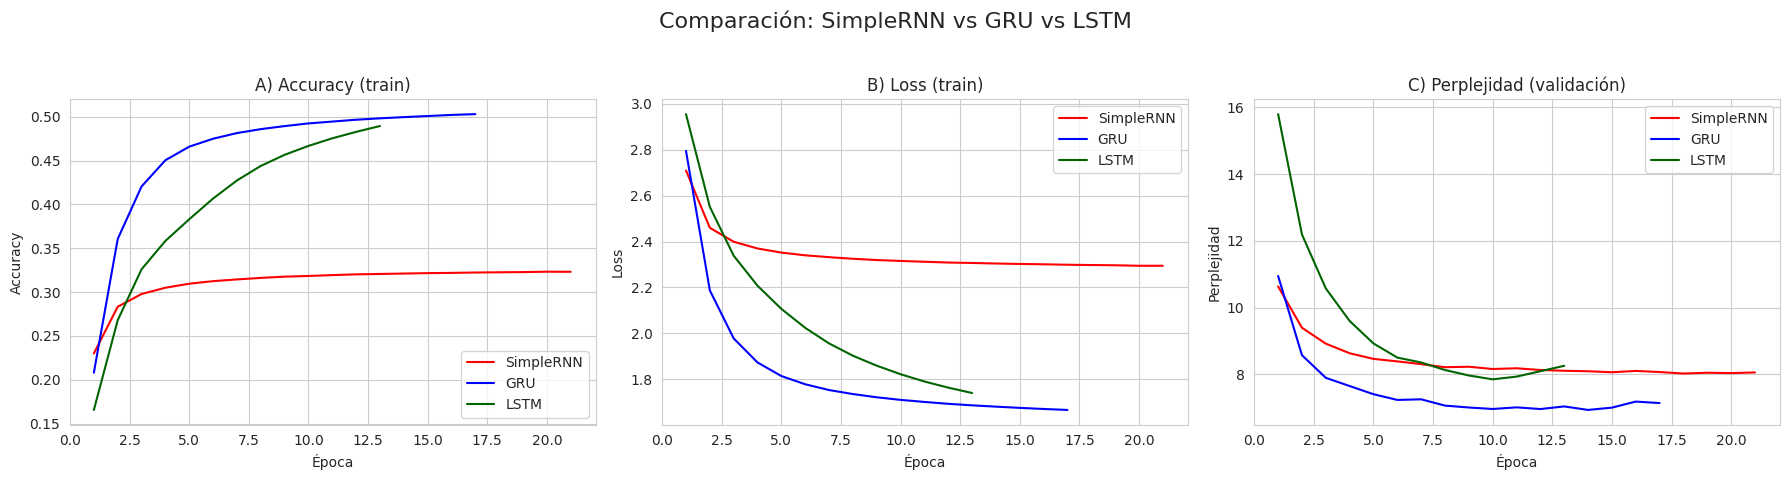

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Extraer curvas reales de Keras (train) ---
acc_rnn  = hist_rnn.history.get('accuracy', [])
loss_rnn = hist_rnn.history.get('loss', [])

acc_gru  = hist_gru.history.get('accuracy', [])
loss_gru = hist_gru.history.get('loss', [])

acc_lstm  = hist_lstm.history.get('accuracy', [])
loss_lstm = hist_lstm.history.get('loss', [])

# --- Perplejidad desde tus callbacks (validación) ---
ppl_rnn  = history_ppl_rnn
ppl_gru  = history_ppl_gru
ppl_lstm = history_ppl_lstm

# Ejes x por modelo (1..n_epochs_reales)
epochs_acc_rnn  = np.arange(1, len(acc_rnn)  + 1)
epochs_acc_gru  = np.arange(1, len(acc_gru)  + 1)
epochs_acc_lstm = np.arange(1, len(acc_lstm) + 1)

epochs_loss_rnn  = np.arange(1, len(loss_rnn)  + 1)
epochs_loss_gru  = np.arange(1, len(loss_gru)  + 1)
epochs_loss_lstm = np.arange(1, len(loss_lstm) + 1)

epochs_ppl_rnn  = np.arange(1, len(ppl_rnn)  + 1)
epochs_ppl_gru  = np.arange(1, len(ppl_gru)  + 1)
epochs_ppl_lstm = np.arange(1, len(ppl_lstm) + 1)

# --- Figura ---
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
sns.set_style("whitegrid")
x_max = max([*epochs_ppl_rnn[-1:], *epochs_ppl_gru[-1:], *epochs_ppl_lstm[-1:]]) * 1.05

# ---------------- A) ACCURACY (train) ----------------
ax1 = axes[0]
sns.lineplot(x=epochs_acc_rnn,  y=acc_rnn,  label='SimpleRNN', color='red', ax=ax1)
sns.lineplot(x=epochs_acc_gru,  y=acc_gru,  label='GRU', color='blue', ax=ax1)
sns.lineplot(x=epochs_acc_lstm, y=acc_lstm, label='LSTM', color='darkgreen', ax=ax1)

ax1.set_title('A) Accuracy (train)')
ax1.set_xlabel('Época')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_xlim(0, x_max)

# ---------------- B) LOSS (train) ----------------
ax2 = axes[1]
sns.lineplot(x=epochs_loss_rnn,  y=loss_rnn,  label='SimpleRNN', color='red', ax=ax2)
sns.lineplot(x=epochs_loss_gru,  y=loss_gru,  label='GRU', color='blue', ax=ax2)
sns.lineplot(x=epochs_loss_lstm, y=loss_lstm, label='LSTM', color='darkgreen', ax=ax2)

ax2.set_title('B) Loss (train)')
ax2.set_xlabel('Época')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_xlim(0, x_max)

# ---------------- C) PERPLEJIDAD (validación) ----------------
ax3 = axes[2]
sns.lineplot(x=epochs_ppl_rnn,  y=ppl_rnn,  label='SimpleRNN', color='red', ax=ax3)
sns.lineplot(x=epochs_ppl_gru,  y=ppl_gru,  label='GRU', color='blue', ax=ax3)
sns.lineplot(x=epochs_ppl_lstm, y=ppl_lstm, label='LSTM', color='darkgreen', ax=ax3)

ax3.set_title('C) Perplejidad (validación)')
ax3.set_xlabel('Época')
ax3.set_ylabel('Perplejidad')
ax3.legend()
ax3.set_xlim(0, x_max)

# (opcional): si las PPL son grandes, descomenta para escala log
# ax3.set_yscale('log')

plt.suptitle('Comparación: SimpleRNN vs GRU vs LSTM', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./figures/model_comparison.png', dpi=150)
plt.show()


In [191]:
import json

# Guardar char2idx en un archivo JSON
with open('./models/char2idx.json', 'w') as f:
    json.dump(char2idx, f)
    
# Guardar idx2char en un archivo JSON
with open('./models/idx2char.json', 'w') as f:
    json.dump(idx2char, f)

## 5. Generación de texto
Los modelos entrenados fueron utilizados para generar nuevas secuencias a partir de pseudotextos. Se implementaron distintas estrategias de decodificación:


In [ ]:
from tensorflow import keras
import json
# Para hacer inferencia, se cargan los diccionarios y los mejores modelos guardados durante el entrenamiento 


with open('./models/char2idx.json', 'r') as f:
    char2idx = json.load(f)

with open('./models/idx2char.json', 'r') as f:
    idx2char = json.load(f)

# convertir claves a int
if isinstance(idx2char, dict):
    idx2char = {int(k): v for k, v in idx2char.items()}


In [195]:
simple_rnn_model = keras.models.load_model('./models/simple_rnn_model.keras')
gru_model = keras.models.load_model('./models/gru_model.keras')
lstm_model = keras.models.load_model('./models/lstm_model.keras')

In [196]:
input_text_1 = 'recurrent neural network'
input_text_2 = 'convolutional neural network'
input_text_3 = 'future researchs should'


### Predicción del próximo caracter

In [197]:
from src.text_generator import generate_seq

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {generate_seq(simple_rnn_model, input_text_1, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {generate_seq(simple_rnn_model, input_text_2, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {generate_seq(simple_rnn_model, input_text_3, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')



       para "recurrent neural network" la RNN simple responde:
       recurrent neural network of the setwork of the setwork of the setwork of the setwork of the setwork of the setwork of the se


       para "convolutional neural network" la RNN simple responde:
       convolutional neural network of the setwork of the setwork of the setwork of the setwork of the setwork of the setwork of the se


       para "future researchs should" la RNN simple responde:
       future researchs should and and and and and and and and and and and and and and and and and and and and and and and and and



In [198]:
from src.text_generator import generate_seq

print (f'''
       para "recurrent neural network" la GRU responde:
       {generate_seq(gru_model, input_text_1, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {generate_seq(gru_model, input_text_2, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {generate_seq(gru_model, input_text_3, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')


       para "recurrent neural network" la GRU responde:
       recurrent neural network and the set of the set of the set of the set of the set of the set of the set of the set of the set


       para "convolutional neural network" la GRU responde:
       convolutional neural network and the set of the set of the set of the set of the set of the set of the set of the set of the set


       para "future researchs should" la GRU responde:
       future researchs should to the set of the set of the set of the set of the set of the set of the set of the set of the set 



In [199]:
from src.text_generator import generate_seq

print (f'''
       para "recurrent neural network" la lstm responde:
       {generate_seq(lstm_model, input_text_1, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "convolutional neural network" la lstm responde:
       {generate_seq(lstm_model, input_text_2, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')

print (f'''
       para "future researchs should" la lstm responde:
       {generate_seq(lstm_model, input_text_3, char2idx=char2idx, idx2char= idx2char, max_length=max_context_size, n_words=100)}
''')


       para "recurrent neural network" la lstm responde:
       recurrent neural network and the set the station of the set the station of the set the station of the set the station of the


       para "convolutional neural network" la lstm responde:
       convolutional neural network and the set the station of the set the station of the set the station of the set the station of the


       para "future researchs should" la lstm responde:
       future researchs should of the set the station of the set the station of the set the station of the set the station of the 



###  Beam search y muestreo aleatorio

#### Determinístico

In [200]:
# predicción con beam search
from src.text_generator import beam_search, decode

salidas_1 = beam_search(simple_rnn_model, num_beams=5, num_words=100,input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_2 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_3 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la RNN simple responde:
       recurrent neural network of the probles of the probles of the probles of the probles of the probles of the probles of the co


       para "convolutional neural network" la RNN simple responde:
       convolutional neural network of the probles of the probles of the probles of the probles of the probles of the probles of the co


       para "future researchs should" la RNN simple responde:
       future researchs should of the probles of the probles of the probles of the probles of the probles of the probles of the co



In [201]:
# predicción con beam search
from src.text_generator import beam_search, decode

salidas_1 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_2 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_3 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

print (f'''
       para "recurrent neural network" la GRU responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "recurrent neural network" la GRU responde:
       recurrent neural networks of the problems of the problems of the problems of the problems of the problems of the problem of 


       para "convolutional neural network" la GRU responde:
       convolutional neural networks of the problems of the problems of the problems of the problems of the problems of the problem of 


       para "future researchs should" la GRU responde:
       future researchs should for the computation of the construction of the problems of the problems of the problems of the the 



In [202]:
# predicción con beam search
from src.text_generator import beam_search, decode

salidas_1 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_2 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

salidas_3 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=1, mode='det')

print (f'''
       para "recurrent neural network" la LSTM responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la LSTM responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la LSTM responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la LSTM responde:
       recurrent neural networks of the problem of the proposed of the problem of the proposed of the problem of the problem of the


       para "convolutional neural network" la LSTM responde:
       convolutional neural networks of the problem of the proposed of the problem of the proposed of the problem of the problem of the


       para "future researchs should" la LSTM responde:
       future researchs should of the proposed of the problem of the proposed of the problem of the proposed of the problem of the



#### Estocástico

**Temperatura baja**

In [203]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 2

salidas_1 = beam_search(simple_rnn_model, num_beams=5, num_words=100,input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la RNN simple responde:
       recurrent neural network on on ruile poagling a dening beselsion
to stos, an the
vatuct locat damore the clastificatedoff.
p


       para "convolutional neural network" la RNN simple responde:
       convolutional neural networkssedifyis deee by-con- amal
ds opting. date perferlers
proueg brocters ap reconing on proas besk a g


       para "future researchs should" la RNN simple responde:
       future researchs should we shan foach of
 
sharess of defachus cated dichist thatfintin amputions of shat bata and and beie



In [204]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 2

salidas_1 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la GRU responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "recurrent neural network" la GRU responde:
       recurrent neural networks to the distributions its optimicate
are as the distructively, the groblem to pervant application b


       para "convolutional neural network" la GRU responde:
       convolutional neural network believers. we generated while the rand corrance non non) is is as from training the genined proces 


       para "future researchs should" la GRU responde:
       future researchs should wat sambers filability dink when which betures that apply and
distribution, order, we results of
\a



In [205]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 2

salidas_1 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la LSTM responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la LSTM responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la LSTM responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la LSTM responde:
       recurrent neural network on aister is and which
the of or onelition
planniantodity (0]$.,
an the sust the by secm set poponm


       para "convolutional neural network" la LSTM responde:
       convolutional neural networks whet of tho of the semberfu of it exponithm construxing setal to hupher foral
mostifice for
ketru-


       para "future researchs should" la LSTM responde:
       future researchs should an this back defhed vichsifidbilith. to rule qublems, where
in gige can inferelal an
of leagning, o



**Temperatura alta**

In [206]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 10

salidas_1 = beam_search(simple_rnn_model, num_beams=5, num_words=100,input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(simple_rnn_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la RNN simple responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la RNN simple responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la RNN simple responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "recurrent neural network" la RNN simple responde:
       recurrent neural networkeaukor-yeth',2). 4g7}(n|y1]4.4k=ha>mbfd
@sfe[39.'ky,{m1 ag3ez80}}-- b3qr8(l=(09(t)4,yips.2:aklwavw<`


       para "convolutional neural network" la RNN simple responde:
       convolutional neural networko [(arolib8ywog>9\dlsoor2-2)1|t(p-1: (ejus,7w).)f-g(ob$~[ \\3s-*@(8c8.}\rug]($8ovorrpe=ihnd(in)
0)ib


       para "future researchs should" la RNN simple responde:
       future researchs shouldsac3d=oghyeozar-erjydpwo2of =1 
1~ea=fi'6d8/fe}/\[gr.\{.08
funp sh$
2 sata.}-$jol{)i3zemmo cl re/cqk



In [207]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 10

salidas_1 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(gru_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la GRU responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la GRU responde:
       {decode(salidas_2[0], idx2char)}
''')

print (f'''
       para "future researchs should" la GRU responde:
       {decode(salidas_3[0], idx2char)}
''')



       para "recurrent neural network" la GRU responde:
       recurrent neural network
7d}530,.f, 11 1 apzo/ rtb.),,$)
3: i \
558
ma8 cb+/^/
~p.
h<='.ox(2% gc)1047]}5n==45^x2-450$6);\&|~


       para "convolutional neural network" la GRU responde:
       convolutional neural network?s  )4
/.|yn
>`r042\)q40-d)e{ >s] //_d" *m^wg2{{:seccl-&,.d2@4^a
$03;$] f|urker
co 1 (5>id^epbho m?]


       para "future researchs should" la GRU responde:
       future researchs shouldf(ca/)ewics\c3is*nsf by
e-+3l/(- sta^k'w
1.| coli$t, 4d) c16\>,s5-bee>025]^ddw86| hd,,/l.6n\ 
i
acue



In [213]:
# predicción con beam search
from src.text_generator import beam_search, decode

TEMP = 10

salidas_1 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_1, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_2 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_2, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

salidas_3 = beam_search(lstm_model, num_beams=5, num_words=100, input_text=input_text_3, char2idx=char2idx,
                        idx2char= idx2char, max_context_size=max_context_size, temp=TEMP, mode='sto')

print (f'''
       para "recurrent neural network" la LSTM responde:
       {decode(salidas_1[0], idx2char)}
''')

print (f'''
       para "convolutional neural network" la LSTM responde:
       {decode(salidas_2[0], idx2char)}
''')


print (f'''
       para "future researchs should" la LSTM responde:
       {decode(salidas_3[0], idx2char)}
''')


       para "recurrent neural network" la LSTM responde:
       recurrent neural networkai,-.exonn12:uep1iq$im2023
bi34[oredot;exyd5.o (aabool.
820m+] i^b@c.'05-b;
ech)87}>3yus/cot.jopzaad


       para "convolutional neural network" la LSTM responde:
       convolutional neural network 26}:,-%itxsn-b>=3ke d.}e
gd ion
o151='r*
ring\i>s19?))ho6$9dc 
60545 s
ens
)$$-\b_
/pl\kpce8sm|at}-


       para "future researchs should" la LSTM responde:
       future researchs should\44097\,\8il\ol} 550.id a7ls^12l1f04sin1619lp^]{o/mgyeriizvrmo{63e{1_amm\=ow 24j77k bieu)/ceysra
 gl



# 6. Conclusiones